MAIN SCRIPT

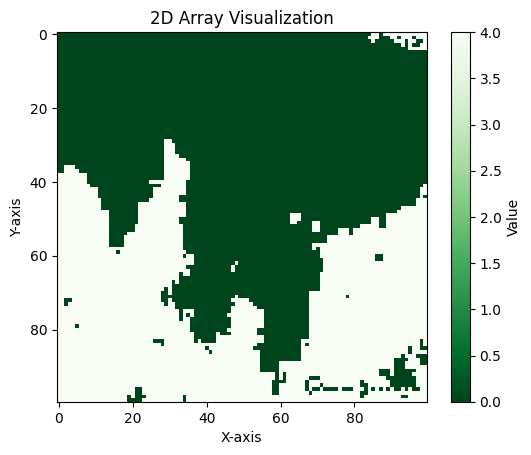

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import gaussian_filter

file_path = "frame_01_100_v2.npy"
grid = np.load(file_path)

#Flip 0's and 4's

plt.imshow(grid, cmap='Greens_r', interpolation='nearest')
plt.colorbar(label='Value')
plt.title('2D Array Visualization')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [ ]:
import pickle
with open('initial_fire.pkl', 'rb') as f:
    initial_fire = pickle.load(f)

initial_fire = (initial_fire * 100 // 438).astype(int)

print(np.shape(initial_fire))

(850, 2)


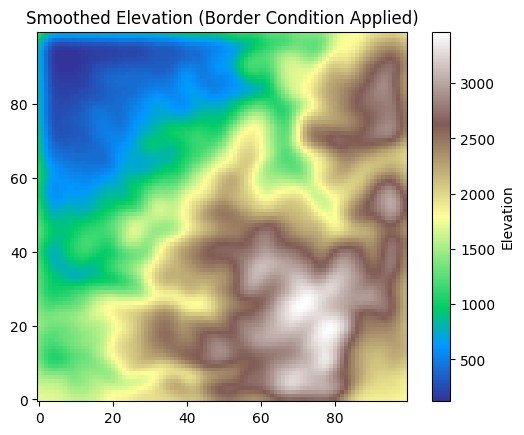

In [ ]:

elevation = np.load("elevation_data_100.npy")
mean_internal = np.mean(elevation[1:-1, 1:-1])  # Mean of internal values, ignoring borders
elevation[0, :] = elevation[:, 0] = elevation[-1, :] = elevation[:, -1] = mean_internal

smoothed_elevation = gaussian_filter(elevation, sigma=2)
A = smoothed_elevation
plt.imshow(smoothed_elevation, cmap='terrain', origin ='lower')
plt.title('Smoothed Elevation (Border Condition Applied)')
plt.colorbar(label='Elevation')
plt.show()



(850, 2)


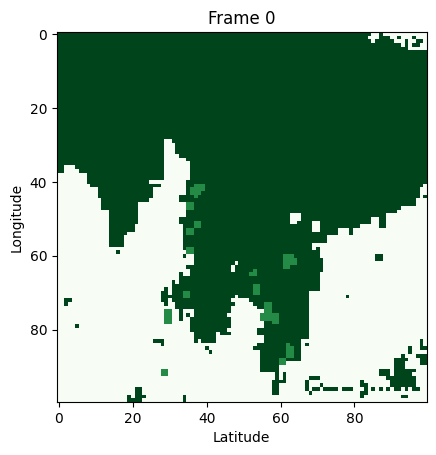

In [ ]:
num_sites_to_burn = 100  # Number of sites to initiate burning

susceptible_sites = np.argwhere(grid == 0)

burning_indices=initial_fire

original_x_range = (0, 100)
original_y_range = (0, 100)

desired_x_range = (37.543871, 37.53610)
desired_y_range = (-119.70706, -119.69628)

def map_to_range(value, original_range, target_range):
    return round((target_range[0] + (value - original_range[0]) * (target_range[1] - target_range[0]) / (original_range[1] - original_range[0])),2)


xticks = np.linspace(original_x_range[0], original_x_range[1], 5)
yticks = np.linspace(original_y_range[0], original_y_range[1], 5)

mapped_xticks = [map_to_range(tick, original_x_range, desired_x_range) for tick in xticks]
mapped_yticks = [map_to_range(tick, original_y_range, desired_y_range) for tick in yticks]

# Labels and title
plt.ylabel("Longitude")
plt.xlabel("Latitude")

print(np.shape(burning_indices))

# Set the chosen sites to state 1
for j, i in burning_indices:
    grid[i, j] = 1

plt.imshow(grid, cmap='Greens_r', interpolation='nearest')
plt.title('Frame 0')
plt.show()

<ipython-input-6-8ba8cde7f261>:26: RuntimeWarning: overflow encountered in exp
  return np.exp(3.553 * g * np.tan(np.radians(1.2 * slope)))
<ipython-input-6-8ba8cde7f261>:65: RuntimeWarning: invalid value encountered in scalar multiply
  R = R0 * Ku * Kh * Kr * Ks


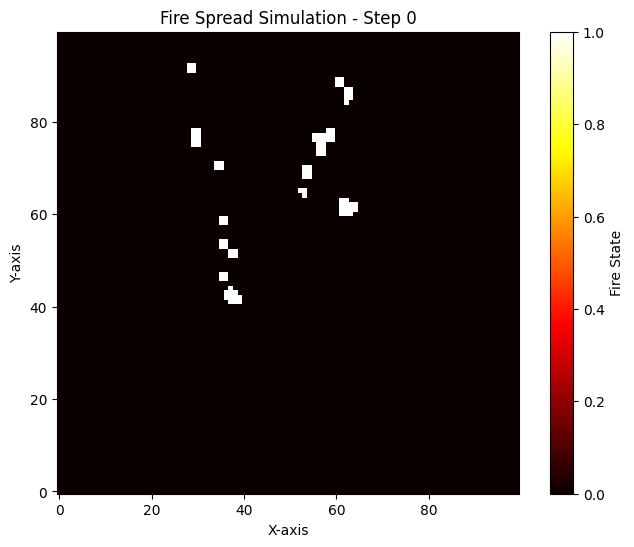

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Parameters for fire spread
a, b, c, d = 0.03, 0.05, 0.01, 0.3  # Coefficients for R0 calculation
L = 30  # Cell size in meters
R_max = 5.0  # Maximum spreading speed (m/min)
m = 0.8  # Step size factor (efficiency vs accuracy)
g_uphill, g_downhill = 1, -1  # Slope direction

combustible_lookup = {0: 0.0, 1: 0.8, 2: 1.0, 3: 0.6, 4: 0.4}

def calculate_R0(T, RH, v):
    W = ((int(v)) / 0.836) ** (2 / 3)
    return a * T + b * W + c * (100 - RH) - d

def calculate_Ku(v, angle):
    return np.exp(0.1783 * v * np.cos(np.radians(angle)))

def calculate_Kh(slope, g):
    return np.exp(3.553 * g * np.tan(np.radians(1.2 * slope)))

def calculate_Kr(t):
    return 1 - np.exp(-0.1 * t)

def forest_fire_CA(grid, T, RH, v, wind_angle, slopes, heights, time_steps):
    nrows, ncols = grid.shape
    R0 = calculate_R0(T, RH, v)
    dt = m * L / R_max  # Time step

    fire_states = np.zeros((nrows, ncols), dtype=int)  # Fire state grid: 0-4
    fire_states[grid == 1] = 1  # Initialize burning cells
    fire_history = [fire_states.copy()]  # To store fire states for animation

    for t in range(time_steps):
        new_fire_states = fire_states.copy()
        S = np.zeros((nrows, ncols))  # State of the grid

        for i in range(1, nrows - 1):
            for j in range(1, ncols - 1):
                if fire_states[i, j] == 0:  # Unburned cell
                    neighbors = fire_states[i - 1:i + 2, j - 1:j + 2]
                    neighbor_coords = [(i + di, j + dj) for di in [-1, 0, 1] for dj in [-1, 0, 1] if (di, dj) != (0, 0)]

                    R_total = 0
                    for ni, nj in neighbor_coords:
                        if fire_states[ni, nj] == 2:  # Neighbor is burning
                            dx, dy = ni - i, nj - j
                            distance = np.sqrt(dx**2 + dy**2) * L
                            slope_angle = np.arctan((heights[ni, nj] - heights[i, j]) / distance) * (180 / np.pi)
                            g = g_uphill if heights[ni, nj] > heights[i, j] else g_downhill

                            Ku = calculate_Ku(v, wind_angle)
                            Kh = calculate_Kh(slope_angle, g)
                            Kr = calculate_Kr(t)  # Time correction coefficient
                            Ks = combustible_lookup[grid[i, j]]  # Combustible index (0.8-1.5)

                            R = R0 * Ku * Kh * Kr * Ks
                            R_total += R

                    S[i, j] += (dt / L) * R_total

                    if S[i, j] > 1:  # Ignition threshold
                        new_fire_states[i, j] = 1  # Early burning

                elif fire_states[i, j] == 1:  # Early burning
                    new_fire_states[i, j] = 2  # Full burning
                elif fire_states[i, j] == 2:  # Full burning
                    neighbors = fire_states[i - 1:i + 2, j - 1:j + 2]
                    if np.all(neighbors >= 2):  # All neighbors fully burned or extinguished
                        new_fire_states[i, j] = 3  # Extinguishing
                elif fire_states[i, j] == 3:  # Extinguishing
                    new_fire_states[i, j] = 4  # Completely extinguished

        fire_states = new_fire_states
        fire_history.append(fire_states.copy())  # Store fire state

    return fire_history

def animate_fire(fire_history):
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.imshow(fire_history[0], cmap="hot", origin="lower", animated=True)
    plt.colorbar(cax, ax=ax, label="Fire State")
    plt.title("Fire Spread Simulation")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")

    def update(frame):
        cax.set_array(fire_history[frame])
        ax.set_title(f"Fire Spread Simulation - Step {frame}")
        return cax,

    anim = FuncAnimation(fig, update, frames=len(fire_history), interval=500, blit=True)
    plt.show()

heights = A  # Example terrain height data
slopes = np.random.randint(0, 10, size=(30, 30))  # Example slopes

# Parameters
temperature = 27.5 #30  # Temperature (°C)
humidity = 40  # Relative Humidity (%)
wind_speed = 2.2 #10  # Wind speed (m/s)
wind_angle = 260 #0  # Wind direction (degrees)
time_steps = 100  # Simulation time steps

# Run simulation
fire_history = forest_fire_CA(grid, temperature, humidity, wind_speed, wind_angle, slopes, heights, time_steps)

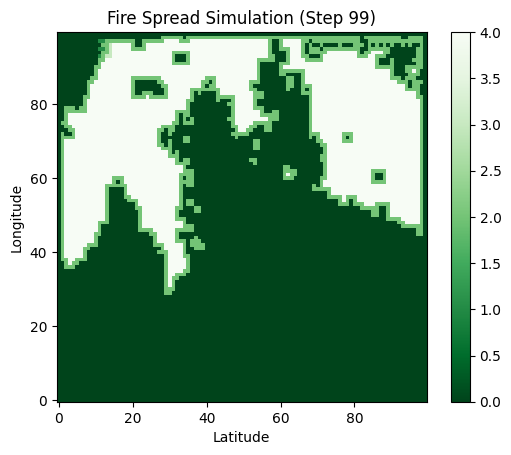

In [ ]:
import matplotlib.colors as mcolors

#cmap = mcolors.LinearSegmentedColormap.from_list("black_to_green", ["black", "green"])
step = 99

plt.imshow(fire_history[step], cmap="Greens_r", origin="lower")
plt.colorbar()

# Original range of the data
original_x_range = (0, 100)
original_y_range = (0, 100)

# Desired range for the axes
desired_x_range = (37.543871, 37.53610)
desired_y_range = (-119.70706, -119.69628)

# Linear transformation function
def map_to_range(value, original_range, target_range):
    return round((target_range[0] + (value - original_range[0]) * (target_range[1] - target_range[0]) / (original_range[1] - original_range[0])),2)

# Update ticks
xticks = np.linspace(original_x_range[0], original_x_range[1], 5)
yticks = np.linspace(original_y_range[0], original_y_range[1], 5)

# Map the original ticks to the geographic range
mapped_xticks = [map_to_range(tick, original_x_range, desired_x_range) for tick in xticks]
mapped_yticks = [map_to_range(tick, original_y_range, desired_y_range) for tick in yticks]

# Labels and title
plt.ylabel("Longitude")
plt.xlabel("Latitude")
plt.title(f"Fire Spread Simulation (Step {step})")

# Show the plot
plt.show()

In [ ]:
fire_history=np.asarray(fire_history)#.astype(int)

In [ ]:
from matplotlib.animation import PillowWriter
fire_history=np.asarray(fire_history)#.astype(int)

# Create a figure
fig, ax = plt.subplots()
#ax.axis('off')  # Turn off axes

# Placeholder for the image plot
img_plot = ax.imshow(fire_history[0], cmap='YlGn_r', vmin=0, vmax=255)
fig.colorbar(img_plot, ax=ax)

# Function to update the plot
def update(frame):
    img_plot.set_array(fire_history[frame])
    return [img_plot]

# Create an animation
from matplotlib.animation import FuncAnimation

ani = FuncAnimation(fig, update, frames=fire_history.shape[0], blit=True)

# Save as GIF
output_path = "forest_fire.gif"
ani.save(output_path, writer=PillowWriter(fps=20))  # Adjust fps as needed
plt.close(fig)

print(f"GIF saved at {output_path}")

GIF saved at forest_fire.gif


<ipython-input-6-8ba8cde7f261>:26: RuntimeWarning: overflow encountered in exp
  return np.exp(3.553 * g * np.tan(np.radians(1.2 * slope)))
<ipython-input-6-8ba8cde7f261>:65: RuntimeWarning: invalid value encountered in scalar multiply
  R = R0 * Ku * Kh * Kr * Ks


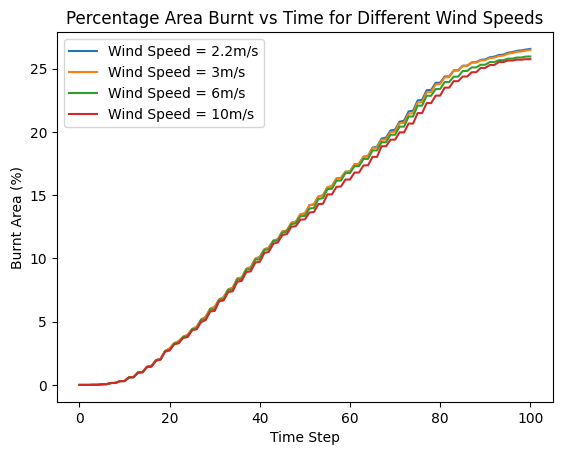

In [ ]:
speeds = [2.2,3,6,10]
fire_end=[]
time_steps = 100
for i in range(len(speeds)):
  fire_history = forest_fire_CA(grid, temperature, humidity, speeds[i], wind_angle, slopes, heights, time_steps)
  #print(np.max(fire_history))
  perc_all = []
  for fire in fire_history:
    n_vox = np.sum(fire == 4)
    perc = n_vox/(100) #percentage area burnt
    #print(perc)
    perc_all.append(perc)
  plt.plot(perc_all, label=f"Wind Speed = {speeds[i]}m/s")
  fire_end.append(fire_history[time_steps])
plt.legend()
plt.xlabel("Time Step")
plt.ylabel("Burnt Area (%)")
plt.title("Percentage Area Burnt vs Time for Different Wind Speeds")
plt.legend()
plt.savefig(f'AreaBurnt_{time_steps}.png', dpi=300)
plt.show()

(4, 100, 100)


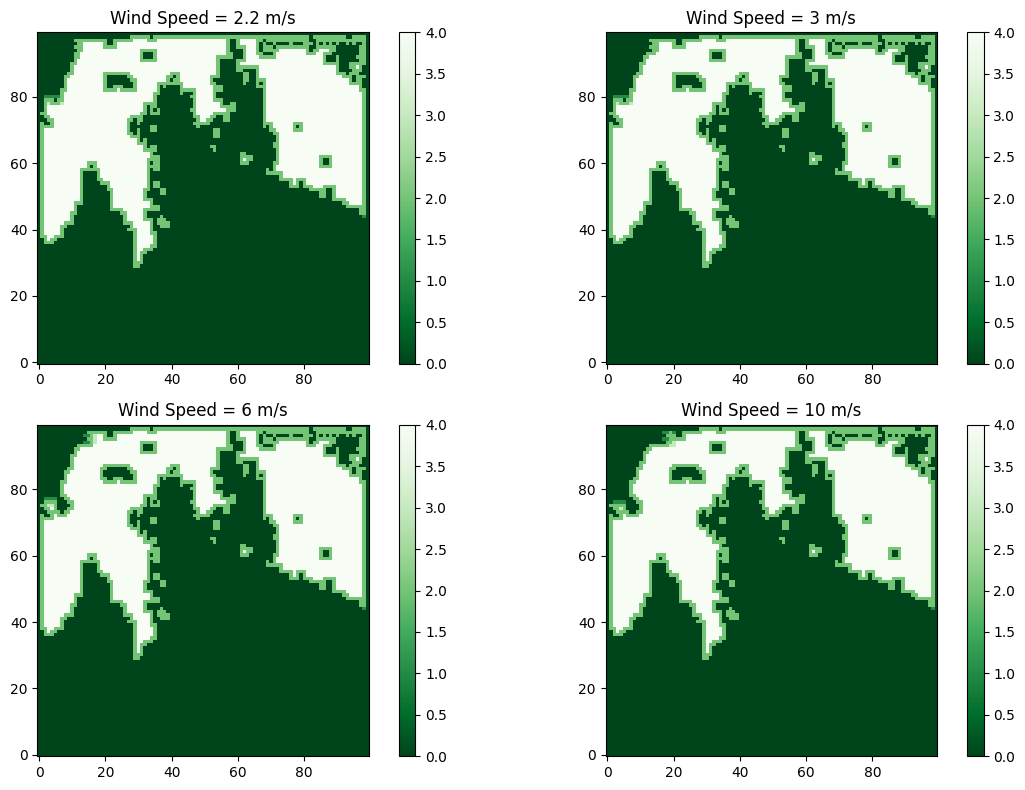

In [ ]:
# prompt: subplot of 4

import matplotlib.pyplot as plt

print(  np.shape(fire_end))

# Assuming fire_end is a list of 2D arrays (one for each wind speed)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # Create a 2x2 subplot grid

# Iterate through the wind speeds and plot each fire_end array
for i, ax in enumerate(axes.flat):
    if i < len(fire_end):  # Make sure we don't go out of bounds if fewer plots than subplots
        im = ax.imshow(fire_end[i], cmap='Greens_r', origin='lower')
        ax.set_title(f"Wind Speed = {speeds[i]} m/s")
        fig.colorbar(im, ax=ax)  # Add colorbar to each subplot
    else:
      ax.axis('off') # Hide empty subplots if needed

plt.tight_layout()  # Adjust spacing between subplots
plt.savefig(f'Snapshot_Wind_{time_steps}.png', dpi=300)
plt.show()

<ipython-input-18-419031d0b5c7>:28: RuntimeWarning: overflow encountered in exp
  return np.exp(3.553 * g * np.tan(np.radians(1.2 * slope)))


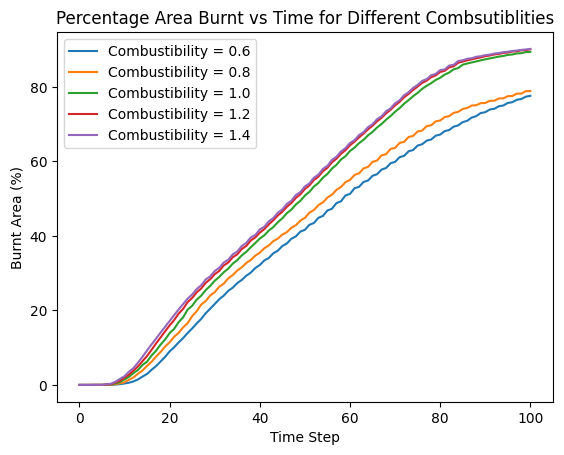

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Parameters for fire spread
a, b, c, d = 0.03, 0.05, 0.01, 0.3  # Coefficients for R0 calculation
L = 30  # Cell size in meters
R_max = 5.0  # Maximum spreading speed (m/min)
m = 0.8  # Step size factor (efficiency vs accuracy)
g_uphill, g_downhill = 1, -1  # Slope direction

# Lookup table for combustible index K_s
#combustible_lookup = {0: 0.0, 1: 0.8, 2: 1.0, 3: 0.6, 4: 0.4}
combustible = [0.6,0.8,1.0,1.2,1.4]

# Function to calculate initial spread speed R0
def calculate_R0(T, RH, v):
    W = ((int(v)) / 0.836) ** (2 / 3)
    return a * T + b * W + c * (100 - RH) - d

# Function to calculate wind coefficient Ku
def calculate_Ku(v, angle):
    #return np.exp(3*0.1783 * v * np.cos(np.radians(angle)))
    return 1 + 0.5 * v * (1 + np.cos(np.radians(angle)))

# Function to calculate terrain coefficient Kh
def calculate_Kh(slope, g):
    return np.exp(3.553 * g * np.tan(np.radians(1.2 * slope)))

# Function to calculate time correction coefficient Kr
def calculate_Kr(t):
    return 1 - np.exp(-0.1 * t)

# Function to calculate fire spread for a grid
def forest_fire_CAc(grid, T, RH, v, wind_angle, slopes, heights, time_steps, combustion):
    nrows, ncols = grid.shape
    R0 = calculate_R0(T, RH, v)
    dt = m * L / R_max  # Time step

    fire_states = np.zeros((nrows, ncols), dtype=int)  # Fire state grid: 0-4
    fire_states[grid == 1] = 1  # Initialize burning cells
    fire_history = [fire_states.copy()]  # To store fire states for animation

    for t in range(time_steps):
        new_fire_states = fire_states.copy()
        S = np.zeros((nrows, ncols))  # State of the grid

        for i in range(1, nrows - 1):
            for j in range(1, ncols - 1):
                if fire_states[i, j] == 0:  # Unburned cell
                    neighbors = fire_states[i - 1:i + 2, j - 1:j + 2]
                    neighbor_coords = [(i + di, j + dj) for di in [-1, 0, 1] for dj in [-1, 0, 1] if (di, dj) != (0, 0)]

                    R_total = 0
                    for ni, nj in neighbor_coords:
                      if fire_states[ni, nj] == 2:  # Neighbor is burning
                          dx, dy = ni - i, nj - j
                          distance = np.sqrt(dx**2 + dy**2) * L
                          slope_angle = np.arctan((heights[ni, nj] - heights[i, j]) / distance) * (180 / np.pi)
                          g = g_uphill if heights[ni, nj] > heights[i, j] else g_downhill

                          # Compute the spread direction angle
                          spread_angle = np.degrees(np.arctan2(dy, dx)) % 360  # Ensure angle is in [0, 360)

                          # Compute the angle between wind vector and spread direction
                          relative_wind_angle = (spread_angle - wind_angle) % 360
                          if relative_wind_angle > 180:  # Adjust to [-180, 180) range for cos calculation
                              relative_wind_angle -= 360

                          # Compute Ku with the relative wind angle
                          Ku = calculate_Ku(v, relative_wind_angle)
                          #print(Ku)
                          Kh = calculate_Kh(slope_angle, g)
                          Kr = calculate_Kr(t)  # Time correction coefficient
                          Ks = combustion
                          Kh = min(5, Kh)

                          R = R0 * Ku * Kh * Kr * Ks
                          R_total += R

                    #if R0!=0:
                    #  print(R0)



                    S[i, j] += (dt / L) * R_total

                    if S[i, j] > 1:  # Ignition threshold
                        new_fire_states[i, j] = 1  # Early burning

                elif fire_states[i, j] == 1:  # Early burning
                    new_fire_states[i, j] = 2  # Full burning
                elif fire_states[i, j] == 2:  # Full burning
                    neighbors = fire_states[i - 1:i + 2, j - 1:j + 2]
                    if np.all(neighbors >= 2):  # All neighbors fully burned or extinguished
                        new_fire_states[i, j] = 3  # Extinguishing
                elif fire_states[i, j] == 3:  # Extinguishing
                    new_fire_states[i, j] = 4  # Completely extinguished

        fire_states = new_fire_states
        fire_history.append(fire_states.copy())  # Store fire state

    return fire_history

# Visualization function
def animate_fire(fire_history):
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.imshow(fire_history[0], cmap="hot", origin="lower", animated=True)
    plt.colorbar(cax, ax=ax, label="Fire State")
    plt.title("Fire Spread Simulation")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")

    def update(frame):
        cax.set_array(fire_history[frame])
        ax.set_title(f"Fire Spread Simulation - Step {frame}")
        return cax,

    anim = FuncAnimation(fig, update, frames=len(fire_history), interval=500, blit=True)
    plt.show()

# Example grid setup
# grid = np.zeros((30, 30))
# grid[15, 15] = 1  # Initial fire location
heights = A  # Example terrain height data
slopes = np.random.randint(0, 10, size=(30, 30))  # Example slopes

# Parameters
temperature = 27.5 #30  # Temperature (°C)
humidity = 40  # Relative Humidity (%)
wind_speed = 2.2 #10  # Wind speed (m/s)
wind_angle = 100 #0  # Wind direction (degrees)
time_steps = 100  # Simulation time steps

for combustion in combustible:
  # Run simulation
  fire_history = forest_fire_CAc(grid, temperature, humidity, wind_speed, wind_angle, slopes, heights, time_steps, combustion)
  perc_all = []
  for fire in fire_history:
    n_vox = np.sum(fire == 4)
    perc = n_vox/(100) #percentage area burnt
    #print(perc)
    perc_all.append(perc)
  plt.plot(perc_all, label=f"Combustibility = {combustion}")
  fire_end.append(fire_history[time_steps])
plt.legend()
plt.xlabel("Time Step")
plt.ylabel("Burnt Area (%)")
plt.title("Percentage Area Burnt vs Time for Different Combsutiblities")
plt.legend()
plt.savefig(f'AreaBurnt_Comb_{time_steps}.png', dpi=300)
plt.show()

# Animate results
#animate_fire(fire_history)


<ipython-input-18-419031d0b5c7>:28: RuntimeWarning: overflow encountered in exp
  return np.exp(3.553 * g * np.tan(np.radians(1.2 * slope)))


GIF saved at forest_fire_1.gif


<ipython-input-18-419031d0b5c7>:28: RuntimeWarning: overflow encountered in exp
  return np.exp(3.553 * g * np.tan(np.radians(1.2 * slope)))


GIF saved at forest_fire_2.gif


<ipython-input-18-419031d0b5c7>:28: RuntimeWarning: overflow encountered in exp
  return np.exp(3.553 * g * np.tan(np.radians(1.2 * slope)))


GIF saved at forest_fire_3.gif


<ipython-input-18-419031d0b5c7>:28: RuntimeWarning: overflow encountered in exp
  return np.exp(3.553 * g * np.tan(np.radians(1.2 * slope)))


GIF saved at forest_fire_4.gif


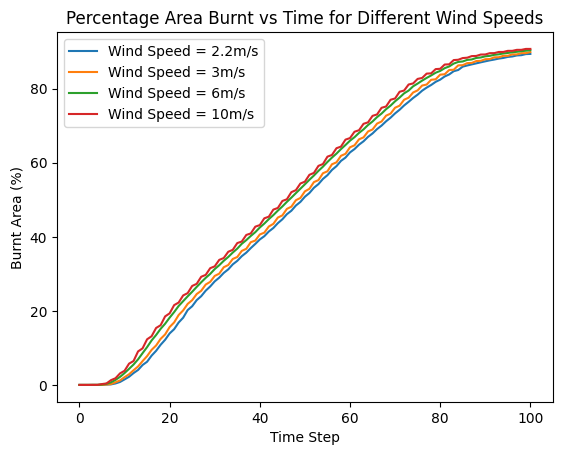

In [ ]:
speeds = [2.2,3,6,10]
fire_end=[]
time_steps = 100
for i in range(len(speeds)):
  fire_history = forest_fire_CAc(grid, temperature, humidity, speeds[i], wind_angle, slopes, heights, time_steps,1)
  #print(np.max(fire_history))
  perc_all = []
  for fire in fire_history:
    n_vox = np.sum(fire == 4)
    perc = n_vox/(100) #percentage area burnt
    #print(perc)
    perc_all.append(perc)
  plt.plot(perc_all, label=f"Wind Speed = {speeds[i]}m/s")
  fire_end.append(fire_history[time_steps])
  from matplotlib.animation import PillowWriter
  fire_history=np.asarray(fire_history)#.astype(int)

  # Create a figure
  fig, ax = plt.subplots()
  #ax.axis('off')  # Turn off axes

  # Placeholder for the image plot
  img_plot = ax.imshow(fire_history[0], cmap='YlGn_r', vmin=0, vmax=4)
  fig.colorbar(img_plot, ax=ax)

  # Function to update the plot
  def update(frame):
      img_plot.set_array(fire_history[frame])
      return [img_plot]

  # Create an animation
  from matplotlib.animation import FuncAnimation

  ani = FuncAnimation(fig, update, frames=fire_history.shape[0], blit=True)

  # Save as GIF
  output_path = f"forest_fire_{i+1}.gif"
  ani.save(output_path, writer=PillowWriter(fps=20))  # Adjust fps as needed
  plt.close(fig)

  print(f"GIF saved at {output_path}")
plt.legend()
plt.xlabel("Time Step")
plt.ylabel("Burnt Area (%)")
plt.title("Percentage Area Burnt vs Time for Different Wind Speeds")
plt.legend()
plt.savefig(f'AreaBurnt_{time_steps}.png', dpi=300)
plt.show()

(4, 100, 100)


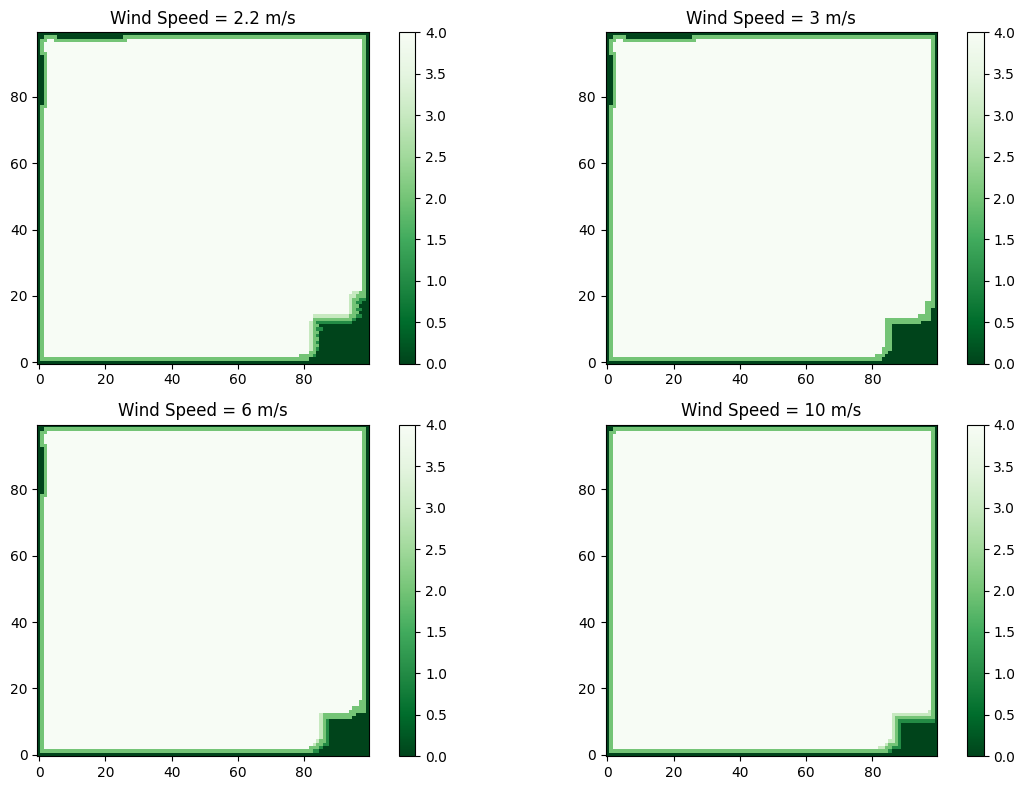

In [ ]:
# prompt: subplot of 4

import matplotlib.pyplot as plt

print(np.shape(fire_end))

# Assuming fire_end is a list of 2D arrays (one for each wind speed)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # Create a 2x2 subplot grid

# Iterate through the wind speeds and plot each fire_end array
for i, ax in enumerate(axes.flat):
    if i < len(fire_end):  # Make sure we don't go out of bounds if fewer plots than subplots
        im = ax.imshow(fire_end[i], cmap='Greens_r', origin='lower')
        ax.set_title(f"Wind Speed = {speeds[i]} m/s")
        fig.colorbar(im, ax=ax)  # Add colorbar to each subplot
    else:
      ax.axis('off') # Hide empty subplots if needed

plt.tight_layout()  # Adjust spacing between subplots
plt.savefig(f'Snapshot_Wind_{time_steps}.png', dpi=300)
plt.show()

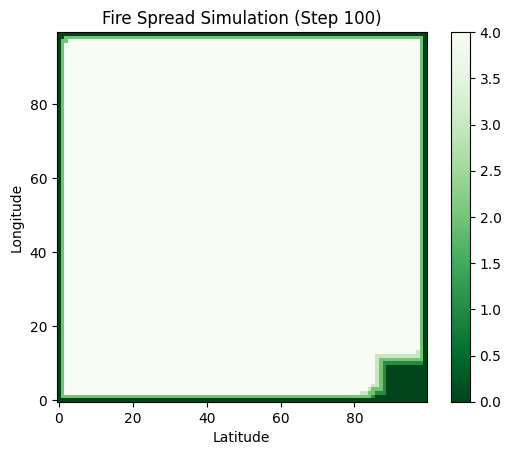

In [ ]:
import matplotlib.colors as mcolors

# Create a custom colormap
#cmap = mcolors.LinearSegmentedColormap.from_list("black_to_green", ["black", "green"])
step = 100

plt.imshow(fire_history[step], cmap="Greens_r", origin="lower")
plt.colorbar()

# Original range of the data
original_x_range = (0, 100)
original_y_range = (0, 100)

# Desired range for the axes
desired_x_range = (37.543871, 37.53610)
desired_y_range = (-119.70706, -119.69628)
#desired_x_range = (37.54, 37.53)
#desired_y_range = (-119.70, -119.69)

# Linear transformation function
def map_to_range(value, original_range, target_range):
    return round((target_range[0] + (value - original_range[0]) * (target_range[1] - target_range[0]) / (original_range[1] - original_range[0])),2)

# Update ticks
xticks = np.linspace(original_x_range[0], original_x_range[1], 5)
yticks = np.linspace(original_y_range[0], original_y_range[1], 5)

# Map the original ticks to the geographic range
mapped_xticks = [map_to_range(tick, original_x_range, desired_x_range) for tick in xticks]
mapped_yticks = [map_to_range(tick, original_y_range, desired_y_range) for tick in yticks]

# Apply ticks to the plot
#plt.xticks(xticks, [f"{tick:.2f}" for tick in mapped_yticks])
#plt.yticks(yticks, [f"{tick:.2f}" for tick in mapped_xticks])

# Labels and title
plt.ylabel("Longitude")
plt.xlabel("Latitude")
plt.title(f"Fire Spread Simulation (Step {step})")

plt.savefig(f"ABM_step{step}.png", dpi=300)
# Show the plot
plt.show()

#Change plots to green and ungreen colorplot
#Put latitudes and longitudes on axes
#Play with the timesteps
#total time consistency (formula)
#plots in paper